In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# -------------------------------------------------------
# 1. Dataset Class
# -------------------------------------------------------

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label, img_path



In [11]:
# -------------------------------------------------------
# 2. Load Dataset
# -------------------------------------------------------

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

dataset_path = "data/Training"   # change to Testing if needed
dataset = BrainTumorDataset(dataset_path, transform=transform)

print(f"Total images: {len(dataset)}")
print("Classes:", dataset.classes)



Total images: 5712
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


torch.Size([3, 128, 128])
(128, 128, 3)
torch.Size([3, 128, 128])
(128, 128, 3)
torch.Size([3, 128, 128])
(128, 128, 3)
torch.Size([3, 128, 128])
(128, 128, 3)
torch.Size([3, 128, 128])
(128, 128, 3)
torch.Size([3, 128, 128])
(128, 128, 3)


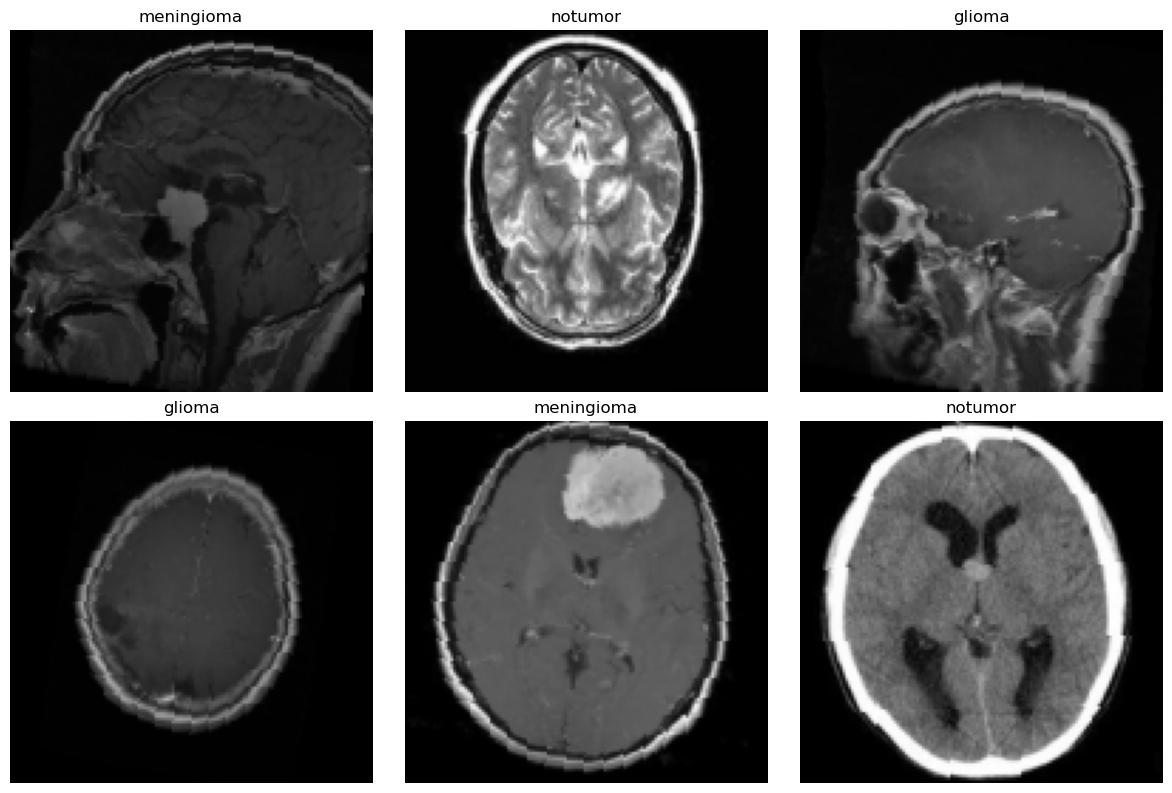

In [ ]:
# -------------------------------------------------------
# 3. Display Random Images
# -------------------------------------------------------

def show_random_images(dataset, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        image, label, path = dataset[idx]

        # Convert tensor → numpy image
        print(image.shape)
        image_np = image.permute(1,2,0).numpy()
        print(image_np.)
        plt.subplot(2, 3, i+1)
        plt.imshow(image_np)
        plt.title(dataset.classes[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(dataset, num_images=6)

In [21]:
trainloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
class CNN_network(nn.modules):
    def __init__(self):
        super(CNN_network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(16 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 4)  # Assuming 4 classes
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

